Import relevant libraries & use uproot to open it.

In [1]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree = uproot.open("outRunNeutron.root")["dstree"]

The different variables contained within the tree.

In [2]:
tree.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
r                          (no str

Training Dataset is the x variable.

In [3]:
train_DS = tree.array("s1ene") / 8000

(array([7.72999834, 0.66257129, 0.88342838, 0.66257129, 0.55214274,
        0.11042855, 0.22085702, 0.11042858, 0.        , 0.11042851]),
 array([0.        , 0.09055629, 0.18111259, 0.27166888, 0.36222517,
        0.45278147, 0.54333776, 0.6338941 , 0.72445035, 0.8150066 ,
        0.90556294], dtype=float32),
 <a list of 10 Patch objects>)

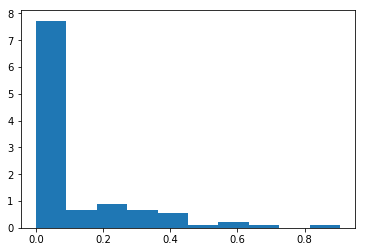

In [4]:
plt.hist(train_DS, density = True)

In [6]:
len(train_DS)

100

In [7]:
num_train = int(1e2)
noise_size = 100

In [8]:
#  Model dependent constants
#  Define model PDF

#The range of the model
range_min, range_max = 0, 1
#The range being plot
range_width = range_max - range_min

plot_resolution = 50

#Initial weights
w1, m1, s1 = 0.5, 8., 1.
w2, m2, s2 = 0.5, 14, 5.

In [9]:
#  Create GAN

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam

#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(50, activation="relu", input_shape=(1,)))
d.add(Dense(50, activation="relu"))
d.add(Dense(50))
d.add(LeakyReLU(0.2))
#Why a softmax?
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(50, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(50, activation="relu"))
g.add(BatchNormalization())
g.add(Dense(50, activation="relu"))
g.add(BatchNormalization())
g.add(Dense(1, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.


Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 5,302
Trainable params: 5,302
Non-trainable params: 0
_________________________________________________________________
Model: "Generator"
_________________________________________________________________
Layer (type)                 Out

In [13]:
#  Func: plot GAN progress

def plot_points_GAN (data, label, epoch, batch_size, d_acc, gan_acc) :
    
    y = plt.hist(train_DS, alpha = 0.3,density = True, label = 'Real Data')
    x = np.linspace(range_min, range_max, 200)
    h = plt.hist(data, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue", alpha=0.6,density = True, label=label)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("x", size=14, labelpad=10)
    #y_max = 1.5*max([max(y),max(h[0])])
    y_max = 0.8
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    '''plt.text(range_min+0.*1.1*range_width   , 0.84*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.750*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.683*1.1*range_width, 0.61*y_max, f"Batch size: {batch_size}")
    plt.text(range_min+0.780*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.text(range_min+0.780*(range_max-range_min), 0.47*y_max, r"$\epsilon_{\rm GAN}$: "+f"{int(100.*gan_acc)}%")
    '''
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    plt.savefig("Train_epoch{epoch}.png", dpi=96)
    plt.show()

In [14]:
#  Train GAN

epochs     = 10000
batch_size = 16
max_D_itrs_per_G_itr_e70 = 4
max_D_itrs_per_G_itr_e52 = 3

train_median, train_std = np.median(train_DS), np.std(train_DS)
quantiles = np.array([.25, .75])
train_quantiles = np.quantile(train_DS, quantiles) - train_median

def update_batch_size (gen_DS) :
    global batch_size
    gen_median, gen_std = np.median(gen_DS.flatten()), np.std(gen_DS.flatten())
    if np.fabs((gen_median-train_median)/train_std) > 1./np.sqrt(batch_size) : return
    if np.fabs((gen_std/train_std)-1) > 1./np.sqrt(batch_size) : return
    '''if batch_size > 200 :
        gen_quantiles = np.quantile(gen_DS, quantiles) - gen_median
        for gen_q, train_q in zip(gen_quantiles, train_quantiles) :
            if np.fabs((gen_q/train_q)-1) > 1./np.sqrt(batch_size) : return'''
    batch_size = min(100+batch_size, num_train)
    
    epochs_saved = []



0.875


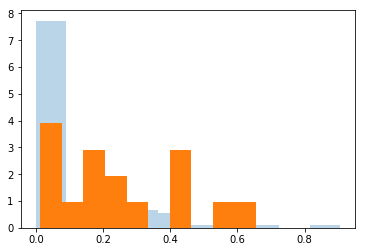

0.90625


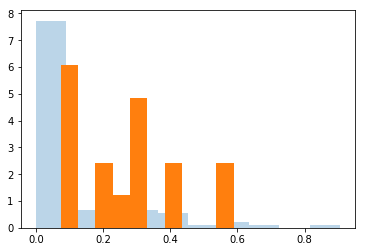

0.875


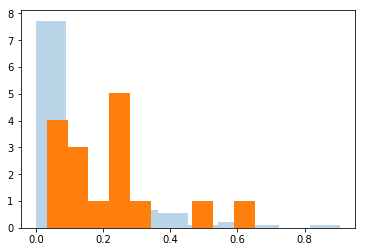

0.8125


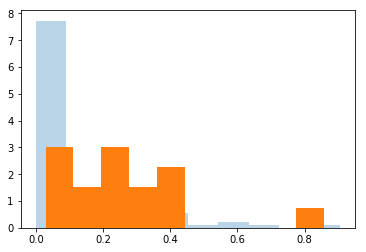

0.875


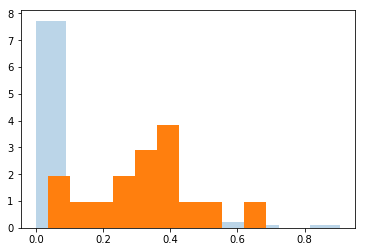

0.84375


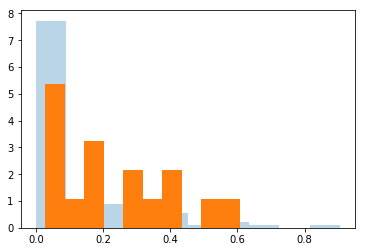

0.875


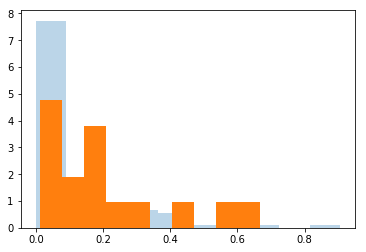

0.84375


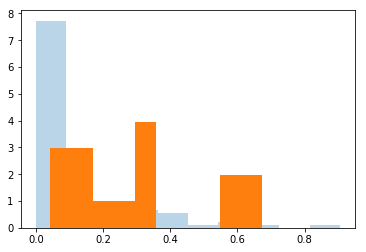

0.78125


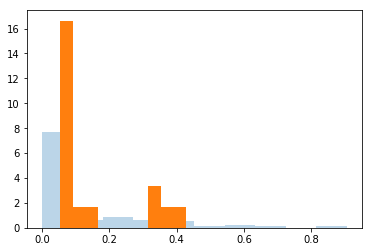

0.875


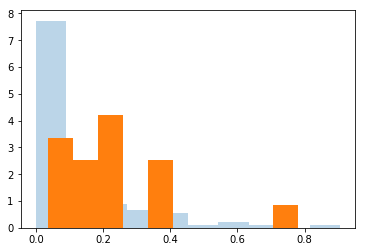

0.90625


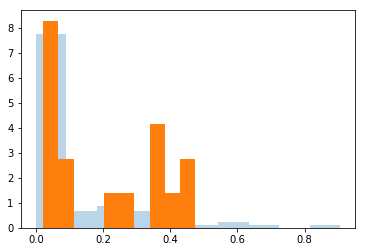

0.75


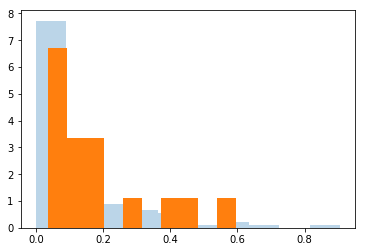

0.8125


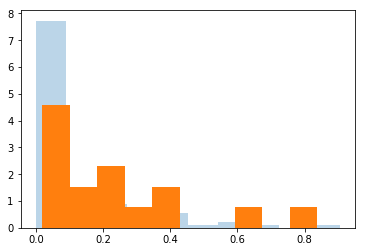

0.78125


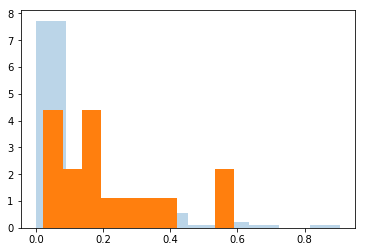

0.8125


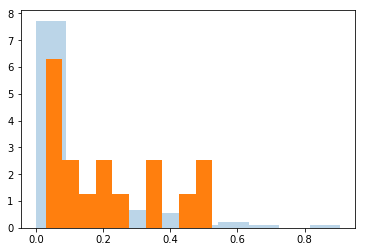

0.71875


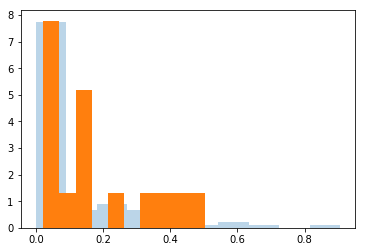

0.78125


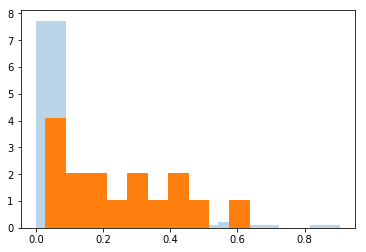

0.71875


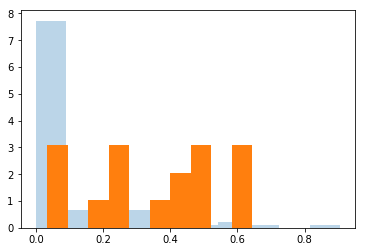

0.75


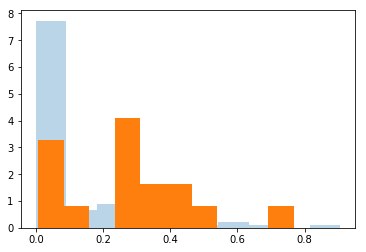

0.875


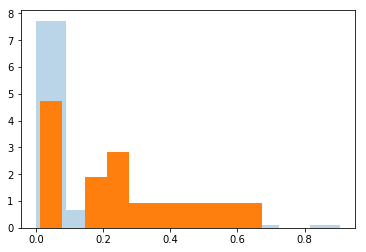

0.8125


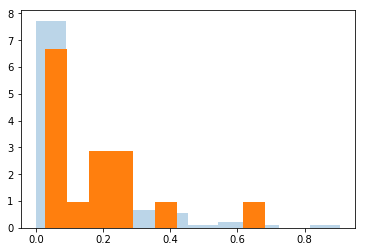

0.78125


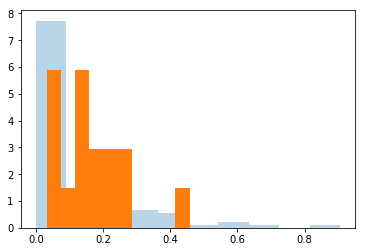

0.90625


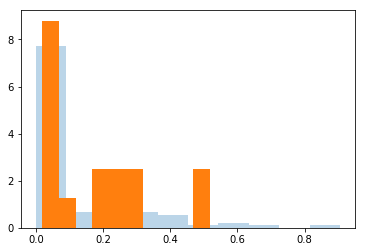

0.75


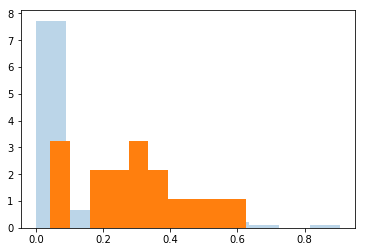

0.71875


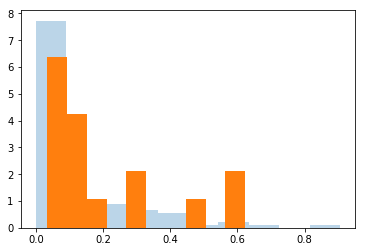

0.78125


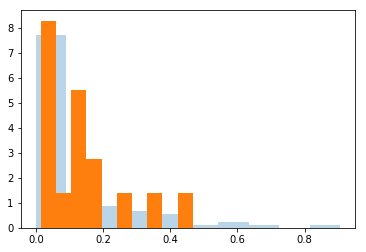

0.78125


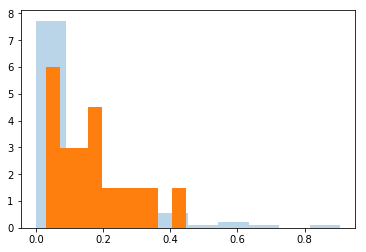

0.84375


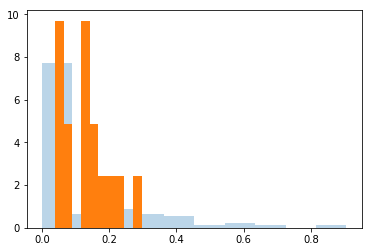

0.84375


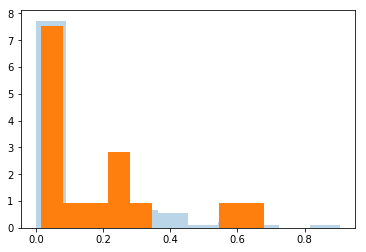

0.84375


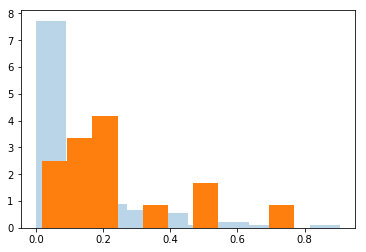

0.8125


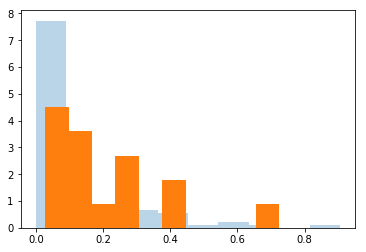

0.78125


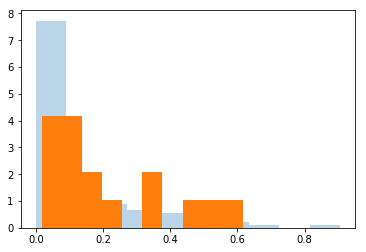

0.78125


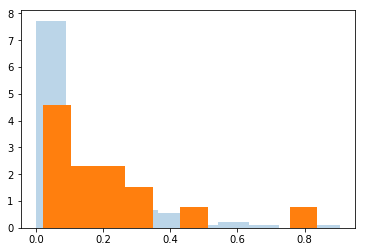

0.75


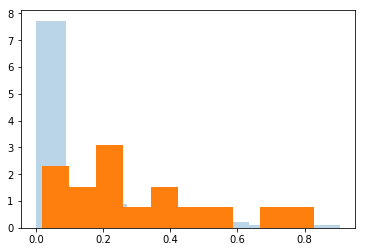

0.75


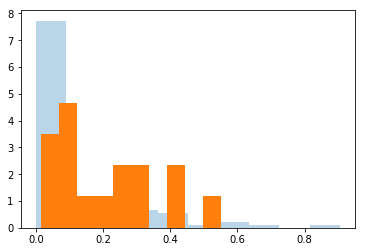

0.875


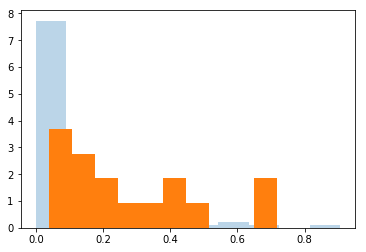

0.8125


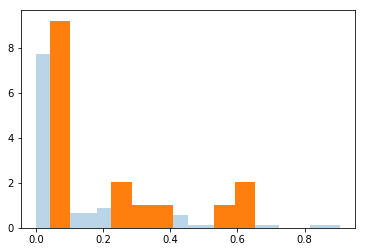

0.8125


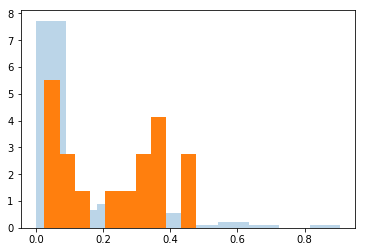

0.8125


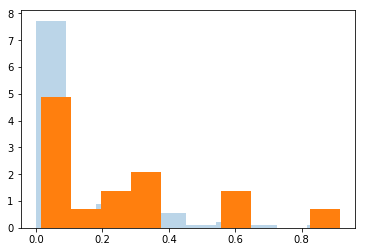

0.71875


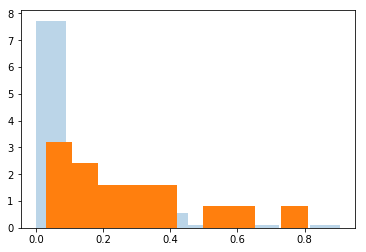

0.8125


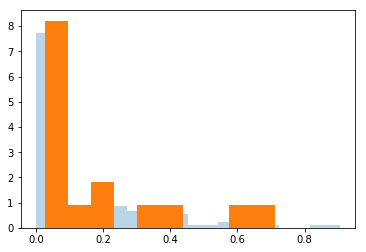

0.8125


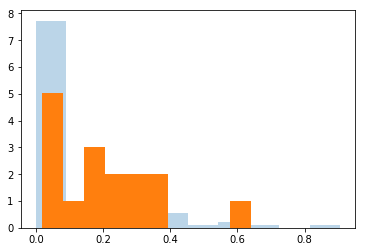

0.90625


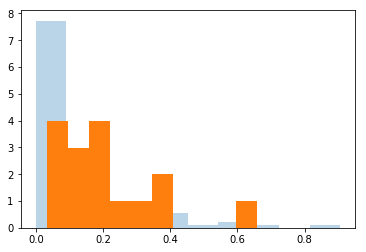

0.78125


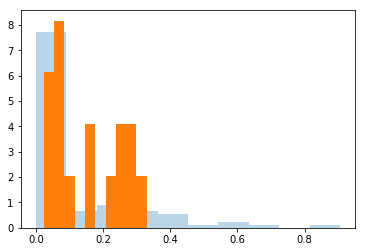

0.78125


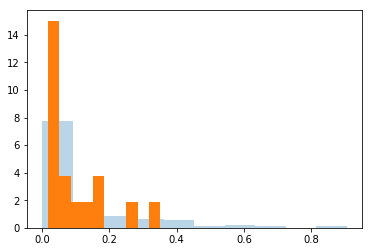

0.84375


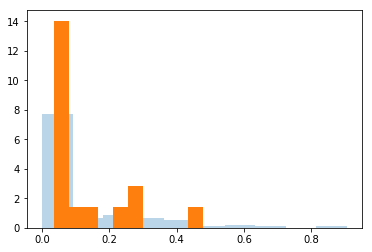

0.8125


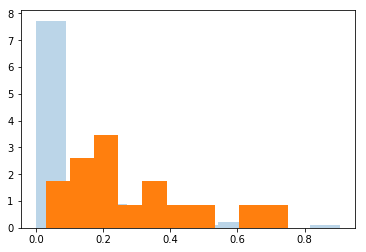

0.84375


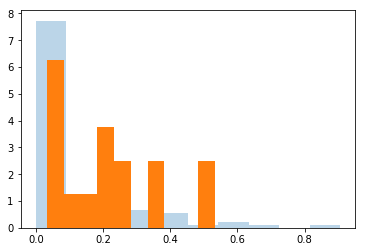

0.71875


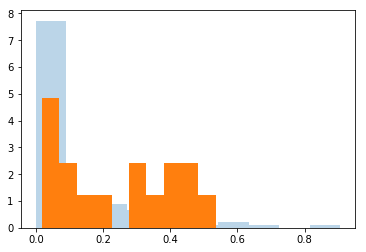

0.78125


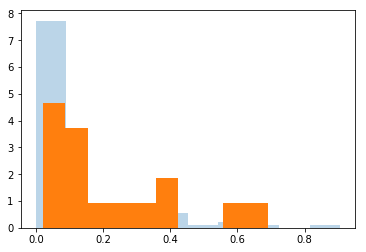

0.84375


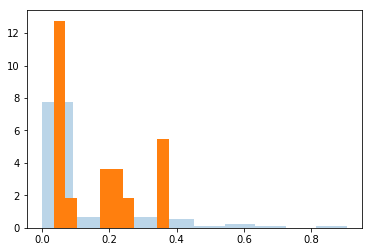

0.8125


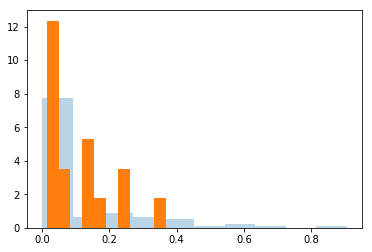

0.84375


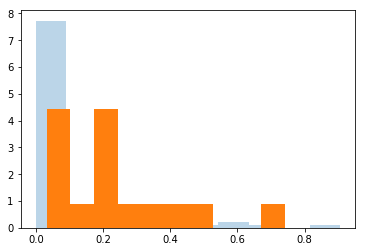

0.84375


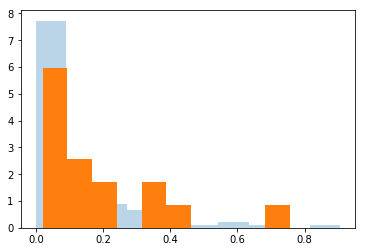

0.875


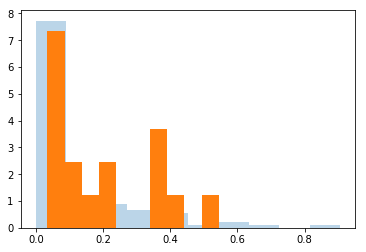

0.78125


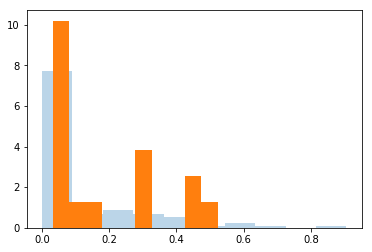

0.71875


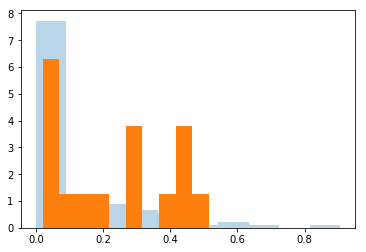

0.875


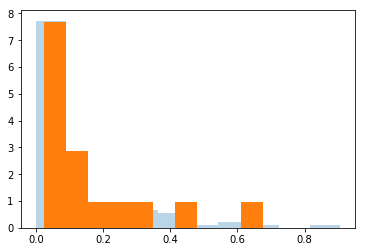

0.71875


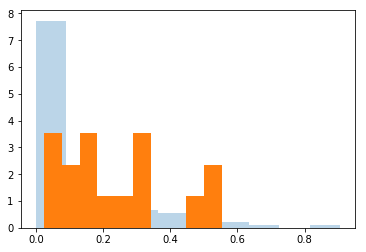

0.84375


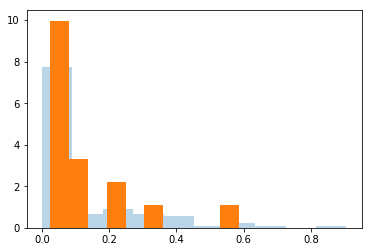

0.8125


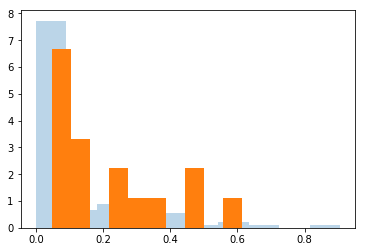

0.84375


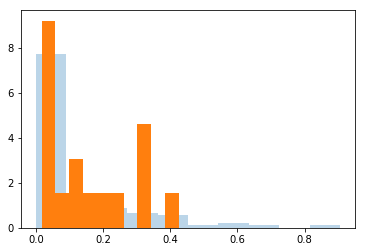

0.6875


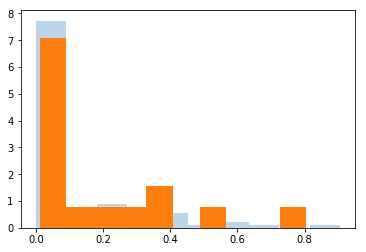

0.78125


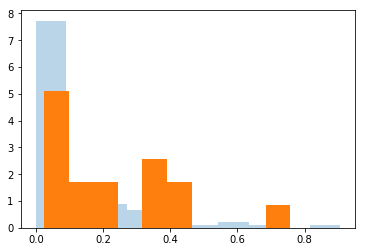

0.75


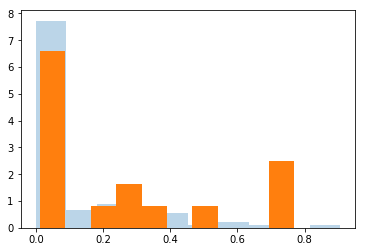

0.71875


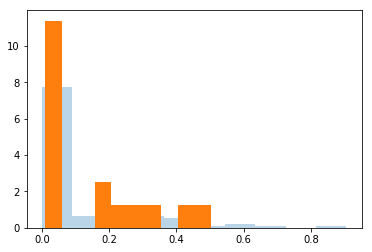

0.78125


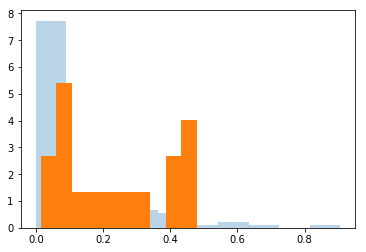

0.84375


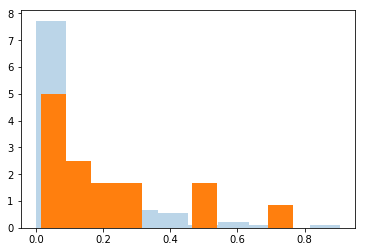

0.6875


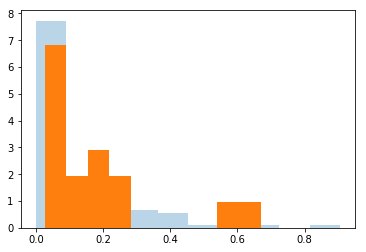

0.8125


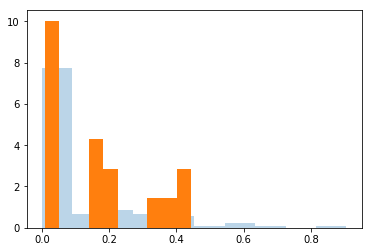

0.8125


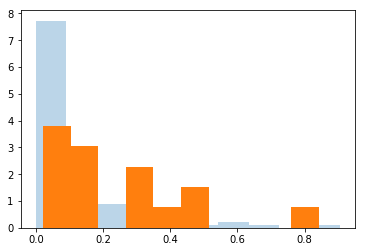

0.84375


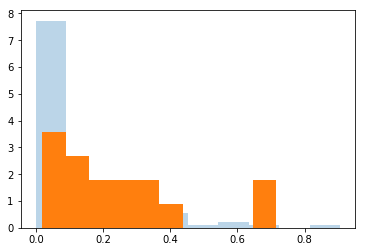

0.90625


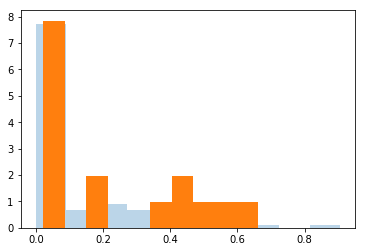

0.78125


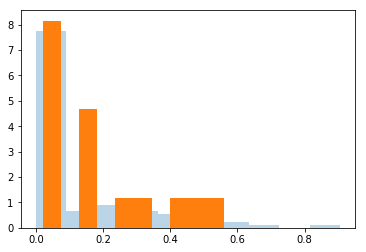

0.78125


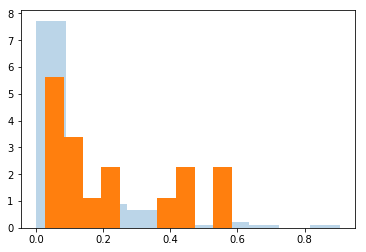

0.75


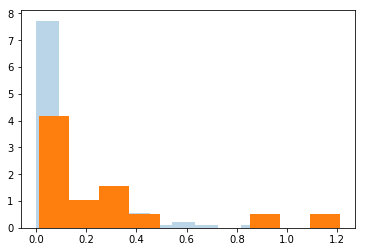

0.6875


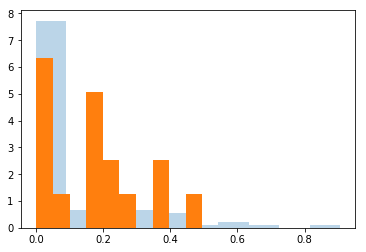

0.875


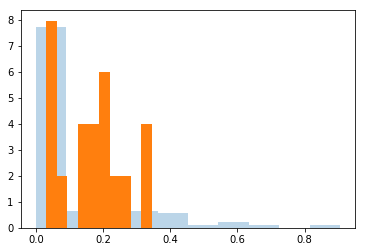

0.8125


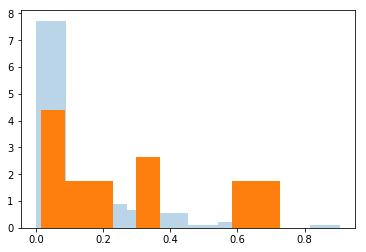

0.78125


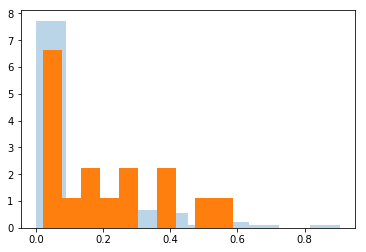

0.75


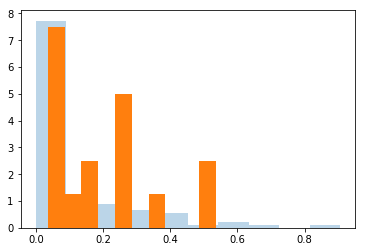

0.90625


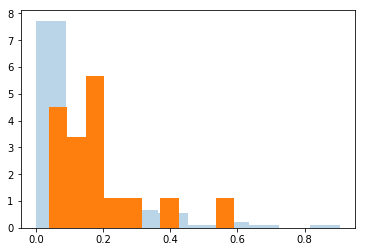

0.90625


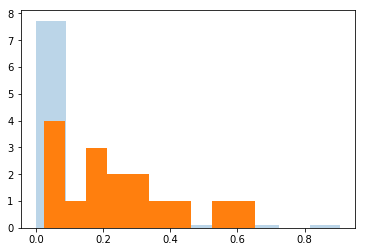

0.71875


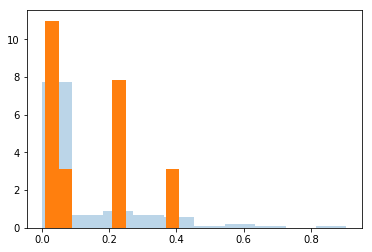

0.78125


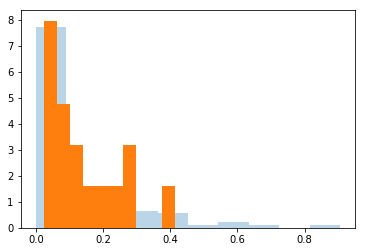

0.875


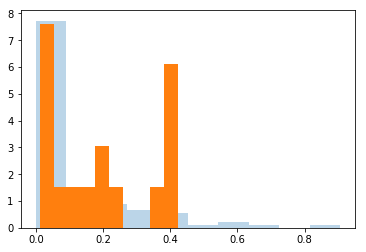

0.8125


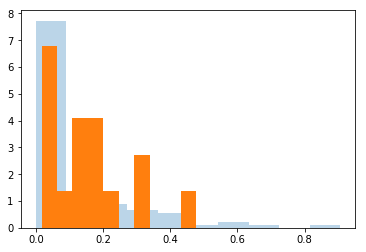

0.78125


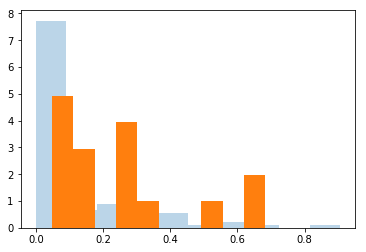

0.78125


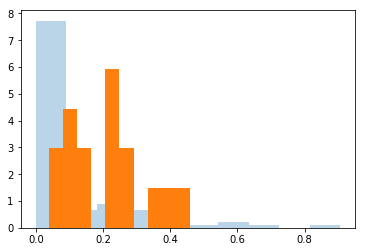

0.75


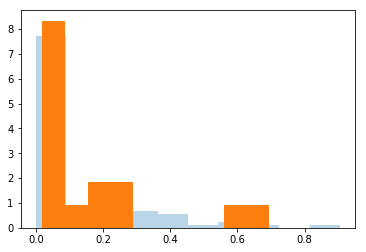

0.78125


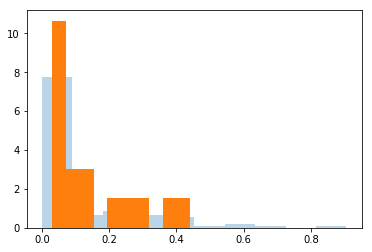

0.6875


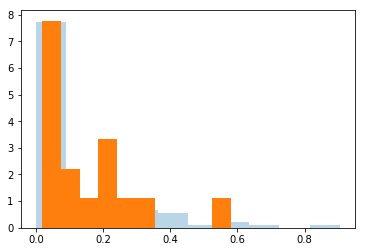

0.9375


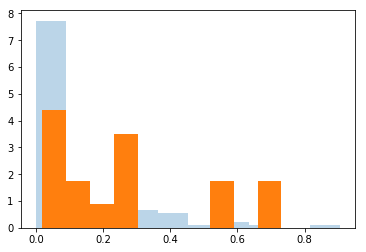

0.8125


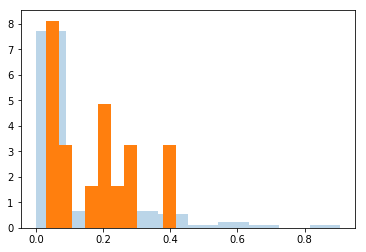

0.84375


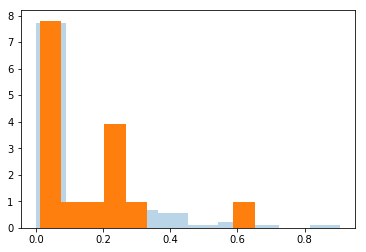

0.875


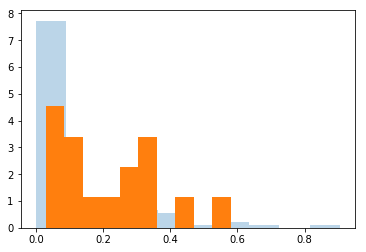

0.875


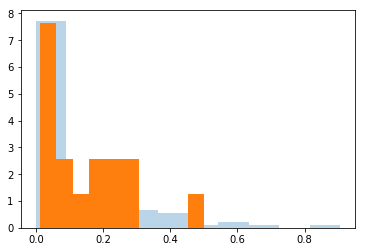

0.78125


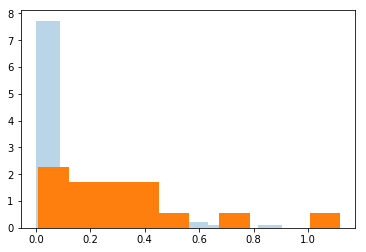

0.65625


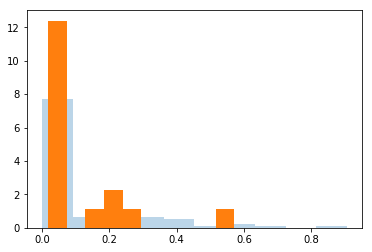

0.6650000214576721


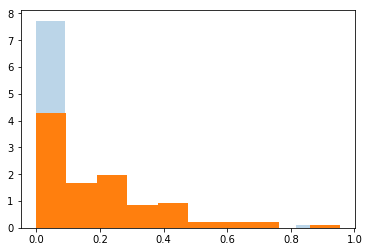

0.75


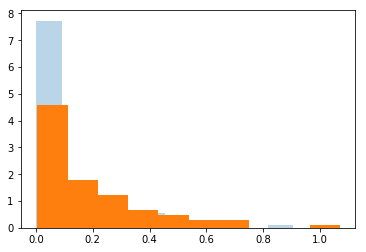

In [20]:
epochs_saved = []
loss = []
epoch_no = []
for e in range(epochs) :
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    
    #Get the real and fake data
    batch_DS = train_DS[np.random.randint(0, len(train_DS), batch_size)].reshape(batch_size, 1)
    #fake data made from predicting noise
    #print(batch_DS)
    gen_DS   = g.predict(noise)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)
    num_itr = 0
    while num_itr < max_D_itrs_per_G_itr_e70 and d_acc < 0.7 :
        d_loss, d_acc = d.train_on_batch(X, Y)
        num_itr = num_itr + 1
    while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
        d_loss, d_acc = d.train_on_batch(X, Y)
        num_itr = num_itr + 1
        
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = np.random.uniform(low = 0., high = 1, size=(batch_size, noise_size))
        gen_DS = g.predict(noise)
        print(d.evaluate(X, Y, verbose=0)[1])
        epoch_no.append(e)
        loss.append(d.evaluate(X, Y, verbose=0)[1])
        plt.hist(train_DS, alpha = 0.3,density = True, label = 'Real Data')
        plt.hist(gen_DS, density = True, label = 'Gen Data')
        plt.show()
        #plot_points_GAN(gen_DS, f"Generated data", 
        #            epoch=e+1, 
        #            batch_size=batch_size, 
        #            d_acc=d.evaluate(X, Y, verbose=0)[1], 
        #            gan_acc=gan.evaluate(noise, real_label, verbose=0)[1])
        update_batch_size(gen_DS)
        epochs_saved.append(e+1)


Plotting Discriminator Accuracy

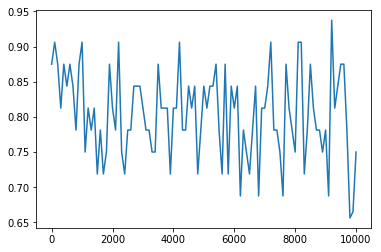

In [21]:
plt.plot(epoch_no,loss)